## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network (1).py
Saving ccm_pruner.py to ccm_pruner (1).py
Saving dataloader.py to dataloader (1).py
Saving model_train_test.py to model_train_test (1).py
Saving requirements.txt to requirements (1).txt
Saving utils.py to utils (1).py
User uploaded file "capsule_network (1).py"
User uploaded file "ccm_pruner (1).py"
User uploaded file "dataloader (1).py"
User uploaded file "model_train_test (1).py"
User uploaded file "requirements (1).txt"
User uploaded file "utils (1).py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [7]:
import os, gc
import random, math
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

Device (CPU/GPU) available to use.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [8]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


## Plots

In [ ]:
def plot_line_chart(arrs, legends, xlabel, ylabel, title, marker='o', line='-'):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = np.arange(1, len(arrs[0])+1)

    for i in range(len(arrs)):
        ax.plot(epochs, arrs[i], marker+line, label = legends[i])

    ax.set_xticks(epochs)
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.set_title(title, fontsize = 16)
    ax.legend()
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()

## Base CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/32Caps8Dim/"

batch_size=64

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:13<00:00, 12796793.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CapsuleNetwork(torch.nn.Module):
    def __init__(self, in_img_c, in_img_h, in_img_w, n_class, *args, **kwargs):

        super(CapsuleNetwork, self).__init__(*args, **kwargs)

        self.name = 'CapsuleNetwork'

        self.conv_layer_1 = caps.ConvLayer(in_channels=in_img_c, out_channels=64, kernel_size=5, stride=1, batch_norm=True)
        self.conv_layer_2 = caps.ConvLayer(in_channels=64, out_channels=128, kernel_size=5, stride=1, batch_norm=True)
        self.conv_layer_3 = caps.ConvLayer(in_channels=128, out_channels=256, kernel_size=5, stride=1, batch_norm=True)

        self.primary_caps = caps.PrimaryCapsLayer(in_channels=256, n_out_caps=32, out_caps_dim=8, kernel_size=5, stride=1)

        prim_caps_out_dim1, prim_caps_out_dim2 = caps.get_n_conv_dim(4, in_img_h, in_img_w, kernel_size=[5, 5, 5, 5],
                                                                     stride=[1, 1, 1, 1], padding=[0, 0, 0, 0])
        n_prim_caps = 32 * prim_caps_out_dim1 * prim_caps_out_dim2

        self.class_caps = caps.CapsLayer(caps_layer_name='class_caps_layer',
                                         n_in_caps=n_prim_caps,
                                         n_out_caps=n_class,
                                         in_caps_dim=8,
                                         out_caps_dim=16)

    def forward(self, images):

        layer_feature_maps = []

        conv_output = self.conv_layer_1(images)
        #layer_feature_maps.append(conv_output.detach().clone())

        conv_output = self.conv_layer_2(conv_output)
        #layer_feature_maps.append(conv_output.detach().clone())

        conv_output = self.conv_layer_3(conv_output)
        #layer_feature_maps.append(conv_output.detach().clone())

        x, primary_caps_output = self.primary_caps(conv_output)
        #layer_feature_maps.append(primary_caps_output.detach().clone())

        pred = self.class_caps(x)

        return None, pred, layer_feature_maps


In [ ]:
base_capsnet_cifar10_model = CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10)
base_capsnet_cifar10_model.name = 'BaseCapsNet_CIFAR10'
base_capsnet_cifar10_model = base_capsnet_cifar10_model.to(device)
base_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

### Training

In [ ]:
# n_class = 10
# n_epochs = 30

# criterion = caps.CapsNetLoss(n_class=n_class)

# best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
#                                                                 base_capsnet_cifar10_model,
#                                                                 criterion,
#                                                                 train_loader,
#                                                                 test_loader,
#                                                                 CIFAR10_TRAIN_DIR,
#                                                                 logger,
#                                                                 device=device)

01/13 01:32:00 AM | BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(0/782), Loss=0.8090, Top 1 Acc=4.69, Top 5 Acc=51.56
INFO:capsnet:BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(0/782), Loss=0.8090, Top 1 Acc=4.69, Top 5 Acc=51.56
01/13 01:32:23 AM | BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(64/782), Loss=0.5916, Top 1 Acc=15.77, Top 5 Acc=62.00
INFO:capsnet:BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(64/782), Loss=0.5916, Top 1 Acc=15.77, Top 5 Acc=62.00
01/13 01:32:47 AM | BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(128/782), Loss=0.5220, Top 1 Acc=24.32, Top 5 Acc=73.90
INFO:capsnet:BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(128/782), Loss=0.5220, Top 1 Acc=24.32, Top 5 Acc=73.90
01/13 01:33:10 AM | BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(192/782), Loss=0.4865, Top 1 Acc=29.02, Top 5 Acc=78.81
INFO:capsnet:BaseCapsNet_CIFAR10 Training - Epoch=1, Iteration=(192/782), Loss=0.4865, Top 1 Acc=29.02, Top 5 Acc=78.81
01/13 01:33:33 AM | 

### Plots for losses and accuracies

In [ ]:
base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_BaseCapsNet_CIFAR10_Epoch30_of_30.pt')

epoch_loss = base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = base_capsnet_cifar10_model['epoch_accuracy']

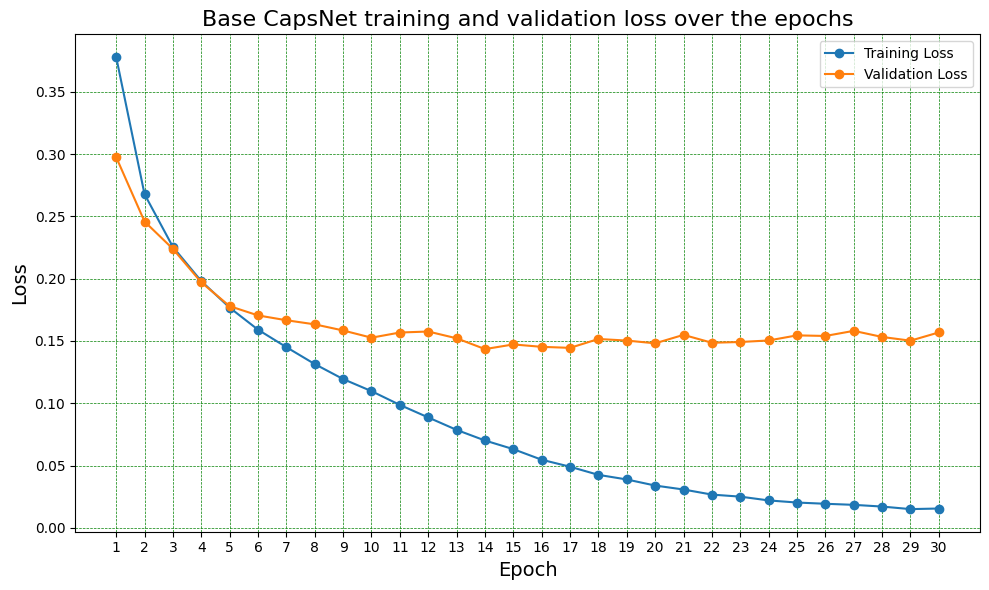

In [ ]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', 'Base CapsNet training and validation loss over the epochs')

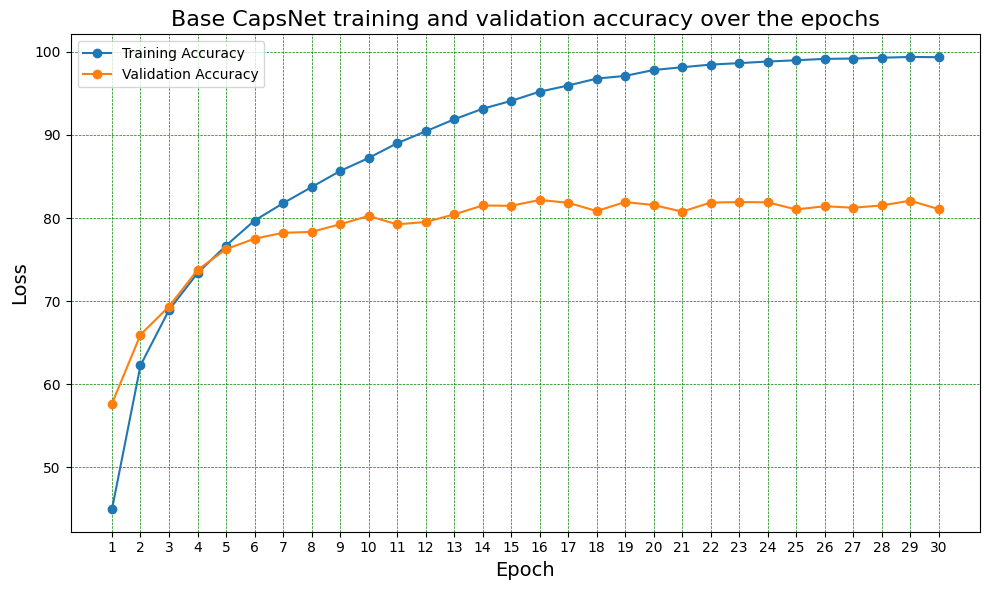

In [ ]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', 'Base CapsNet training and validation accuracy over the epochs')

### Training with CCM loss

In [ ]:
batch_size=64

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/32Caps8Dim/"

base_capsnet_cifar10_ccm_model = CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10)
base_capsnet_cifar10_ccm_model.name = 'BaseCapsNet_CIFAR10_CCM_Model'

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_BaseCapsNet_CIFAR10.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
# %%time
# n_class = 10
# n_epochs = 30

# criterion = caps.CapsNetLoss(n_class=n_class)

# best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
#                                                       base_capsnet_cifar10_ccm_model,
#                                                       criterion,
#                                                       train_loader,
#                                                       test_loader,
#                                                       CIFAR10_TRAIN_DIR,
#                                                       logger,
#                                                       calc_ccm=True,
#                                                       device=device)

01/14 03:19:13 PM | BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(0/782), Loss=-0.0626, Top 1 Acc=96.88, Top 5 Acc=100.00
INFO:capsnet:BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(0/782), Loss=-0.0626, Top 1 Acc=96.88, Top 5 Acc=100.00
01/14 03:19:35 PM | BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(64/782), Loss=-0.0464, Top 1 Acc=95.84, Top 5 Acc=99.69
INFO:capsnet:BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(64/782), Loss=-0.0464, Top 1 Acc=95.84, Top 5 Acc=99.69
01/14 03:19:57 PM | BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(128/782), Loss=-0.0480, Top 1 Acc=96.15, Top 5 Acc=99.62
INFO:capsnet:BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(128/782), Loss=-0.0480, Top 1 Acc=96.15, Top 5 Acc=99.62
01/14 03:20:20 PM | BaseCapsNet_CIFAR10_CCM_Model Training - Epoch=1, Iteration=(192/782), Loss=-0.0494, Top 1 Acc=96.32, Top 5 Acc=99.66
INFO:capsnet:BaseCapsNet_CIFAR10_CCM_Model Training - Epoch

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_BaseCapsNet_CIFAR10_CCM_Model_Epoch18_of_30.pt'

In [ ]:
# best_trained_ccm_model_path = '/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_BaseCapsNet_CIFAR10_CCM_Model_Epoch18_of_30.pt'

# utils.save_best_model(CIFAR10_TRAIN_DIR, base_capsnet_cifar10_ccm_model.name, best_trained_ccm_model_path)

### CCM and CI score calculation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/32Caps8Dim/"

base_capsnet_cifar10_ccm_model = CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10, n_caps_layers=0)
base_capsnet_cifar10_ccm_model.name = 'BaseCapsNet_CIFAR10_CCM_Model'

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_BaseCapsNet_CIFAR10_CCM_Model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

Extract Correlation Coefficient Matrix

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_layers = 4
layer_ccm_list = [ [] for _ in range(n_layers) ]
layer_mean_ccm_list = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            _, batch_ccm = ccmp.calc_ccm_loss(batch_feature_maps)
            layer_ccm_list[indx].append(batch_ccm.detach().cpu())

        torch.cuda.empty_cache()

for i in range(n_layers):
    layer_mean_ccm_list.append(torch.mean(torch.stack(layer_ccm_list[i]), dim=0))

ccmp.save_ccm(layer_mean_ccm_list, CIFAR10_TRAIN_DIR, base_capsnet_cifar10_ccm_model.name+'_ccm')

BaseCapsNet_CIFAR10_CCM_Model_ccm saved
CPU times: user 1min 30s, sys: 8.92 s, total: 1min 38s
Wall time: 1min 38s


Channel Importance Scores

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_layers = 4
layer_ci_list = [ [] for _ in range(n_layers) ]

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            batch_ci_score = ccmp.ci_score(batch_feature_maps)
            layer_ci_list[indx].append(batch_ci_score.detach().cpu().numpy())

        torch.cuda.empty_cache()

    layer_mean_ci_list = []

    for i in range(n_layers):
        layer_mean_ci_list.append(np.mean(layer_ci_list[i], axis=0))

    np.save(CIFAR10_TRAIN_DIR+base_capsnet_cifar10_ccm_model.name+'_ci_scores.npy', np.asarray(layer_mean_ci_list, dtype=object))

CPU times: user 1h 23min 24s, sys: 11.8 s, total: 1h 23min 36s
Wall time: 1h 23min 19s


### Pruning

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/32Caps8Dim/"

n_class=10
batch_size=64

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
pretrained_base_capsnet_cifar10_ccm_model = CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=10)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_BaseCapsNet_CIFAR10_CCM_Model.pt',
                                             map_location=device)

pretrained_base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

pretrained_base_capsnet_cifar10_ccm_model = pretrained_base_capsnet_cifar10_ccm_model.to(device)
pretrained_base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
layers_to_prune_dict = {'conv_layer_1':0,
                        'conv_layer_2':1,
                        'conv_layer_3':2,
                        'primary_caps':3 }

In [ ]:
base_capsnet_cifar10_ccm_model_ci_scores = np.load(CIFAR10_TRAIN_DIR+'BaseCapsNet_CIFAR10_CCM_Model_ci_scores.npy', allow_pickle=True)
base_capsnet_cifar10_ccm_model_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'BaseCapsNet_CIFAR10_CCM_Model_ccm')

In [ ]:
# def build_pruned_capsnet(orig_model, input_channels, n_class, n_caps_layers,
#                          prim_caps_dim, model_layers_to_prune, channels_to_preserve):
#     import copy

#     orig_model_state_dict = orig_model.state_dict()
#     new_model = copy.deepcopy(orig_model)

#     new_conv_layer_n_channels = 0
#     new_pcaps_layer_n_channels = 0
#     curr_conv_input_channels = input_channels

#     for layer_name in model_layers_to_prune:
#         preserve_layer_channels = channels_to_preserve[layer_name]

#         if layer_name.startswith('conv_layer'):
#             existing_kernel_size = orig_model_state_dict[layer_name+'.conv_layer.weight'].shape[-1]
#             new_conv_layer_n_channels = len(preserve_layer_channels)

#             setattr(new_model, layer_name, caps.ConvLayer(in_channels=curr_conv_input_channels,
#                                                           out_channels=new_conv_layer_n_channels,
#                                                           kernel_size=existing_kernel_size,
#                                                           stride=1,
#                                                           batch_norm=True))

#             curr_conv_input_channels = new_conv_layer_n_channels

#         elif layer_name.startswith('primary_caps'):
#             existing_kernel_size = orig_model_state_dict[layer_name+'.primary_caps.weight'].shape[-1]
#             new_pcaps_layer_n_channels = int(len(preserve_layer_channels)/prim_caps_dim)

#             setattr(new_model, layer_name, caps.PrimaryCapsLayer(in_channels=new_conv_layer_n_channels,
#                                                                  n_out_caps=new_pcaps_layer_n_channels,
#                                                                  out_caps_dim=prim_caps_dim,
#                                                                  kernel_size=existing_kernel_size,
#                                                                  stride=1))
#     if n_caps_layers != 0:
#         prev_n_prim_caps = orig_model_state_dict['intermediate_caps.intermediate_caps_layer_1.weights'].shape[0]
#     else:
#         prev_n_prim_caps = orig_model_state_dict['class_caps.weights'].shape[0]

#     prev_prim_caps_out_channels = orig_model_state_dict['primary_caps.primary_caps.weight'].shape[0]

#     feature_dims = int((prev_n_prim_caps*prim_caps_dim)/ prev_prim_caps_out_channels)

#     new_n_prim_caps = feature_dims * new_pcaps_layer_n_channels

#     if n_caps_layers != 0:
#         intermediate_caps = torch.nn.Sequential()
#         intermediate_caps.add_module("intermediate_caps_layer_1",
#                                      caps.CapsLayer(caps_layer_name='intermediate_caps_layer_1',
#                                                     n_in_caps=new_n_prim_caps,
#                                                     n_out_caps=16,
#                                                     in_caps_dim=prim_caps_dim,
#                                                     out_caps_dim=12))
#         if n_caps_layers > 1:
#             for caps_layer in range(2, n_caps_layers+1):
#                 intermediate_caps.add_module("intermediate_caps_layer_" + str(caps_layer),
#                                               caps.CapsLayer(caps_layer_name='intermediate_caps_layer_' + str(caps_layer),
#                                                              n_in_caps=16,
#                                                              n_out_caps=16,
#                                                              in_caps_dim=12,
#                                                              out_caps_dim=12))

#         setattr(new_model, "intermediate_caps", intermediate_caps)

#         setattr(new_model, "class_caps", caps.CapsLayer(caps_layer_name='class_caps_layer',
#                                                         n_in_caps=16,
#                                                         n_out_caps=n_class,
#                                                         in_caps_dim=12,
#                                                         out_caps_dim=16))

#     else:
#         setattr(new_model, "class_caps", caps.CapsLayer(caps_layer_name='class_caps_layer',
#                                                         n_in_caps=new_n_prim_caps,
#                                                         n_out_caps=n_class,
#                                                         in_caps_dim=prim_caps_dim,
#                                                         out_caps_dim=16))

#     return new_model

In [ ]:
# def prune_multilayer_capsnet_layers(orig_model, input_channels, n_class, n_caps_layers,
#                                     prim_caps_dim, model_layers_to_prune, channels_to_preserve,
#                                     device='cuda'):

#     new_model = build_pruned_capsnet(orig_model,
#                                      input_channels=input_channels,
#                                      n_class=n_class,
#                                      n_caps_layers=n_caps_layers,
#                                      prim_caps_dim=prim_caps_dim,
#                                      model_layers_to_prune=model_layers_to_prune,
#                                      channels_to_preserve=channels_to_preserve)
#     new_model.to(device)
#     print("Pruned Model:", new_model.eval())

#     orig_model_state_dict = orig_model.state_dict()
#     new_model_state_dict = new_model.state_dict()

#     prev_layer_channels = np.arange(input_channels)

#     for layer_name in model_layers_to_prune:
#         preserve_layer_channels = channels_to_preserve[layer_name]

#         if layer_name.startswith('conv_layer'):
#             layer_weight_name = layer_name+'.conv_layer.weight'

#             new_layer_weight = torch.index_select(orig_model_state_dict[layer_weight_name], 0, torch.tensor(preserve_layer_channels, device=device))
#             new_layer_weight = torch.index_select(new_layer_weight, 1, torch.tensor(prev_layer_channels, device=device))

#             new_model_state_dict[layer_weight_name] = new_layer_weight

#             layer_bias_name = layer_name+'.conv_layer.bias'
#             if layer_bias_name in orig_model_state_dict.keys():
#                 new_layer_bias = torch.index_select(orig_model_state_dict[layer_bias_name], 0, torch.tensor(preserve_layer_channels, device=device))
#                 new_model_state_dict[layer_bias_name] = new_layer_bias

#             prev_layer_channels = preserve_layer_channels

#         elif layer_name.startswith('primary_caps'):
#             layer_weight_name = layer_name+'.primary_caps.weight'

#             new_layer_weight = torch.index_select(orig_model_state_dict[layer_weight_name], 0, torch.tensor(preserve_layer_channels, device=device))
#             new_layer_weight = torch.index_select(new_layer_weight, 1, torch.tensor(prev_layer_channels, device=device))

#             new_model_state_dict[layer_weight_name] = new_layer_weight

#             layer_bias_name = layer_name+'.primary_caps.bias'
#             new_layer_bias = torch.index_select(orig_model_state_dict[layer_bias_name], 0, torch.tensor(preserve_layer_channels, device=device))
#             new_model_state_dict[layer_bias_name] = new_layer_bias

#     new_model.load_state_dict(new_model_state_dict)

#     return new_model

#### 20% Pruning

In [ ]:
prune_threshold = 0.20

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     base_capsnet_cifar10_ccm_model_ccm, caps_dim=8,
                                                     layers_to_prune=layers_to_prune_dict)

In [ ]:
pruned_20pc_base_capsnet_cifar10_model = ccmp.prune_multilayer_capsnet_layers(pretrained_base_capsnet_cifar10_ccm_model,
                                                                         input_channels=3, n_class=10, n_caps_layers=0, prim_caps_dim=8,
                                                                         model_layers_to_prune=layers_to_prune_dict.keys(),
                                                                         channels_to_preserve=channels_to_preserve, device=device)

pruned_20pc_base_capsnet_cifar10_model.name = 'pruned_20pc_base_capsnet_cifar10_model'
pruned_20pc_base_capsnet_cifar10_model = pruned_20pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(56, 104, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(104, 208, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(208, 208, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
# %%time
# n_epochs=30
# criterion = caps.CapsNetLoss(n_class)

# best_pruned_20pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
#                                                              pruned_20pc_base_capsnet_cifar10_model,
#                                                              criterion,
#                                                              train_loader,
#                                                              test_loader,
#                                                              CIFAR10_TRAIN_DIR,
#                                                              logger,
#                                                              device=device)

01/17 02:15:26 AM | pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8047, Top 1 Acc=7.81, Top 5 Acc=54.69
INFO:capsnet:pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8047, Top 1 Acc=7.81, Top 5 Acc=54.69
01/17 02:15:45 AM | pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6015, Top 1 Acc=23.68, Top 5 Acc=74.95
INFO:capsnet:pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6015, Top 1 Acc=23.68, Top 5 Acc=74.95
01/17 02:16:03 AM | pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5103, Top 1 Acc=33.85, Top 5 Acc=83.50
INFO:capsnet:pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5103, Top 1 Acc=33.85, Top 5 Acc=83.50
01/17 02:16:22 AM | pruned_20pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4580, Top 1 Acc=41.00, Top 5 Acc=87.49
INFO:ca

CPU times: user 2h 33s, sys: 11.4 s, total: 2h 44s
Wall time: 2h 38s


In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(pruned_20pc_base_capsnet_cifar10_model,
                        inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_20pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_20pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_20pc_base_capsnet_cifar10_model CIFAR10 20.0% pruned Flops = 581116032.0
pruned_20pc_base_capsnet_cifar10_model CIFAR10 20.0% pruned Params = 1773144.0


##### Plots for losses and accuracies

In [ ]:
trained_pruned_20pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_20pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_20pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_20pc_base_capsnet_cifar10_model['epoch_accuracy']

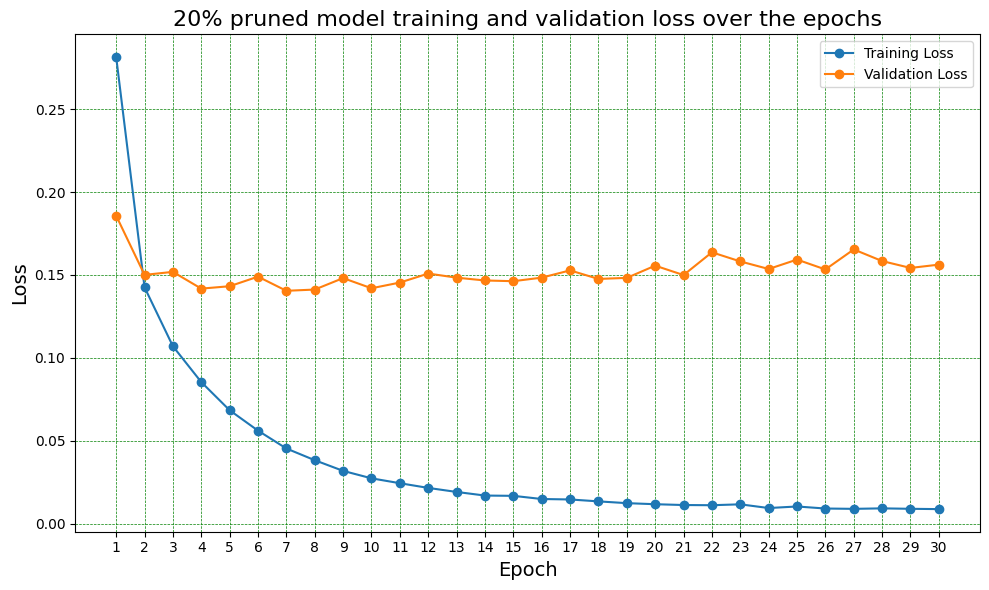

In [ ]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '20% pruned model training and validation loss over the epochs')

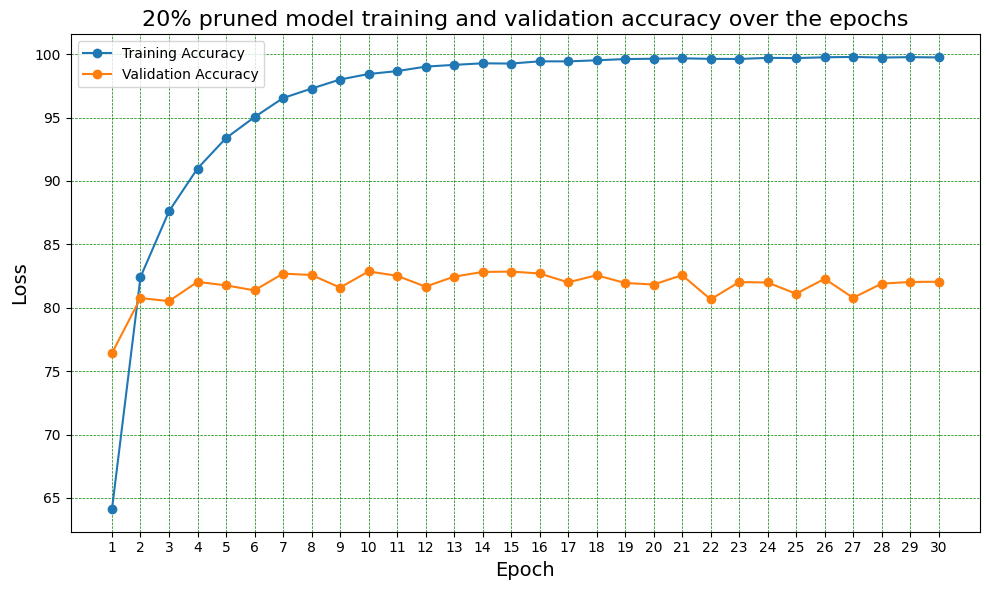

In [ ]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '20% pruned model training and validation accuracy over the epochs')

#### 25% Pruning

In [ ]:
prune_threshold = 0.25

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     base_capsnet_cifar10_ccm_model_ccm, caps_dim=8,
                                                     layers_to_prune=layers_to_prune_dict)

In [ ]:
pruned_25pc_base_capsnet_cifar10_model = ccmp.prune_multilayer_capsnet_layers(pretrained_base_capsnet_cifar10_ccm_model,
                                                                         input_channels=3,
                                                                         n_class=10,
                                                                         n_caps_layers=0,
                                                                         prim_caps_dim=8,
                                                                         model_layers_to_prune=layers_to_prune_dict.keys(),
                                                                         channels_to_preserve=channels_to_preserve,
                                                                         device=device)

pruned_25pc_base_capsnet_cifar10_model.name = 'pruned_25pc_base_capsnet_cifar10_model'
pruned_25pc_base_capsnet_cifar10_model = pruned_25pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
# %%time
# n_epochs=30
# criterion = caps.CapsNetLoss(n_class)

# best_pruned_25pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
#                                                              pruned_25pc_base_capsnet_cifar10_model,
#                                                              criterion,
#                                                              train_loader,
#                                                              test_loader,
#                                                              CIFAR10_TRAIN_DIR,
#                                                              logger,
#                                                              device=device)

01/17 04:19:44 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8044, Top 1 Acc=12.50, Top 5 Acc=50.00
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8044, Top 1 Acc=12.50, Top 5 Acc=50.00
01/17 04:20:01 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6042, Top 1 Acc=23.82, Top 5 Acc=67.96
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6042, Top 1 Acc=23.82, Top 5 Acc=67.96
01/17 04:20:19 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5139, Top 1 Acc=34.10, Top 5 Acc=79.74
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5139, Top 1 Acc=34.10, Top 5 Acc=79.74
01/17 04:20:36 AM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4591, Top 1 Acc=41.73, Top 5 Acc=84.93
INFO:

CPU times: user 1h 51min 1s, sys: 9.07 s, total: 1h 51min 10s
Wall time: 1h 51min 12s


In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(pruned_25pc_base_capsnet_cifar10_model,
                        inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Flops = 490106112.0
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Params = 1502064.0


##### Plots for losses and accuracies

In [ ]:
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_accuracy']

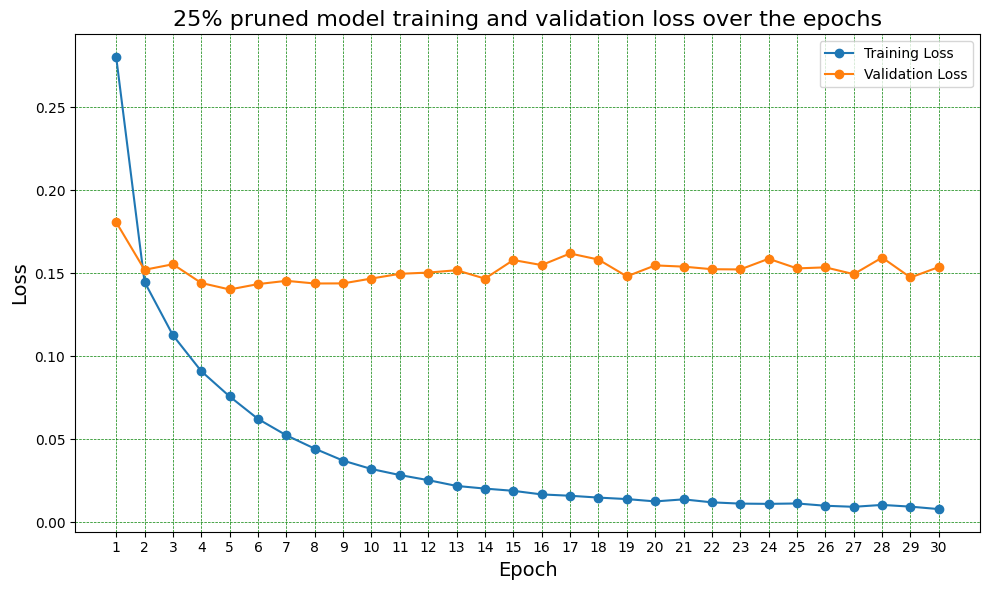

In [ ]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '25% pruned model training and validation loss over the epochs')

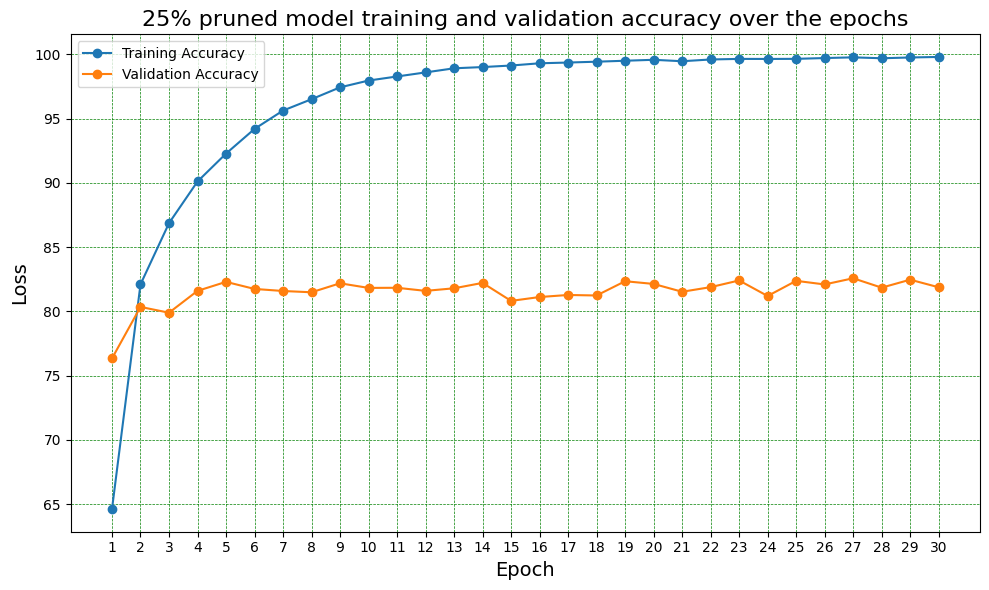

In [ ]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '25% pruned model training and validation accuracy over the epochs')

#### 40% Pruning

In [ ]:
prune_threshold = 0.40

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     base_capsnet_cifar10_ccm_model_ccm, caps_dim=8,
                                                     layers_to_prune=layers_to_prune_dict)

In [ ]:
pruned_40pc_base_capsnet_cifar10_model = ccmp.prune_multilayer_capsnet_layers(pretrained_base_capsnet_cifar10_ccm_model,
                                                                        input_channels=3,
                                                                        n_class=10,
                                                                        n_caps_layers=0,
                                                                        prim_caps_dim=8,
                                                                        model_layers_to_prune=layers_to_prune_dict.keys(),
                                                                        channels_to_preserve=channels_to_preserve,
                                                                        device=device)

pruned_40pc_base_capsnet_cifar10_model.name = 'pruned_40pc_base_capsnet_cifar10_model'
pruned_40pc_base_capsnet_cifar10_model = pruned_40pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
# %%time
# n_epochs=30
# criterion = caps.CapsNetLoss(n_class)

# best_pruned_40pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
#                                                              pruned_40pc_base_capsnet_cifar10_model,
#                                                              criterion,
#                                                              train_loader,
#                                                              test_loader,
#                                                              CIFAR10_TRAIN_DIR,
#                                                              logger,
#                                                              device=device)

01/17 11:05:56 AM | pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8033, Top 1 Acc=6.25, Top 5 Acc=46.88
INFO:capsnet:pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8033, Top 1 Acc=6.25, Top 5 Acc=46.88
01/17 11:06:10 AM | pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5958, Top 1 Acc=20.50, Top 5 Acc=70.55
INFO:capsnet:pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5958, Top 1 Acc=20.50, Top 5 Acc=70.55
01/17 11:06:24 AM | pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5130, Top 1 Acc=32.76, Top 5 Acc=80.79
INFO:capsnet:pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5130, Top 1 Acc=32.76, Top 5 Acc=80.79
01/17 11:06:38 AM | pruned_40pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4623, Top 1 Acc=40.75, Top 5 Acc=85.78
INFO:ca

CPU times: user 1h 33min 33s, sys: 8.4 s, total: 1h 33min 42s
Wall time: 1h 33min 34s


In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(pruned_40pc_base_capsnet_cifar10_model,
                        inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_40pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_40pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_40pc_base_capsnet_cifar10_model CIFAR10 40.0% pruned Flops = 340837760.0
pruned_40pc_base_capsnet_cifar10_model CIFAR10 40.0% pruned Params = 1043720.0


##### Plots for losses and accuracies

In [ ]:
trained_pruned_40pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_40pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_40pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_40pc_base_capsnet_cifar10_model['epoch_accuracy']

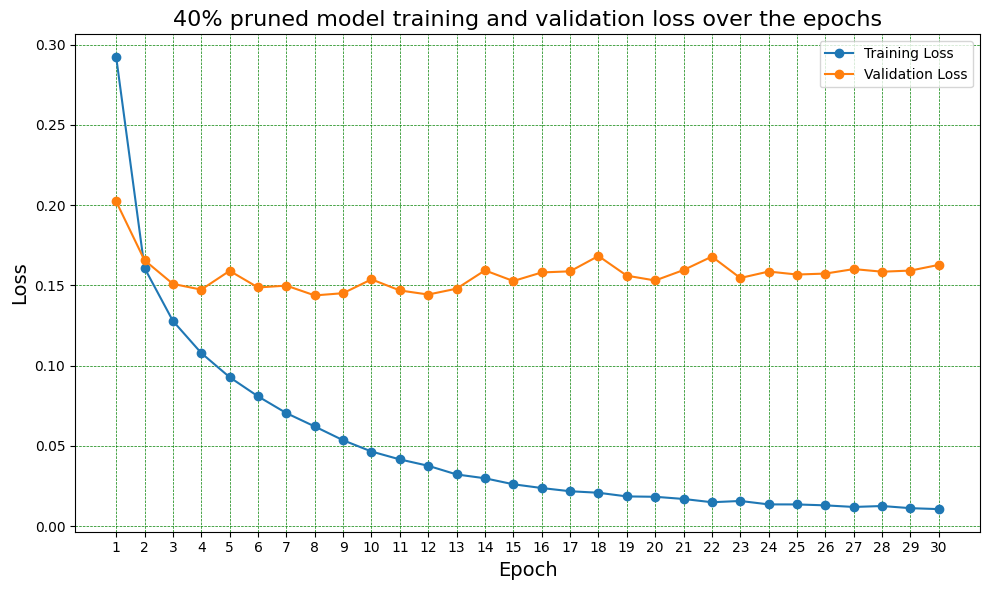

In [ ]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '40% pruned model training and validation loss over the epochs')

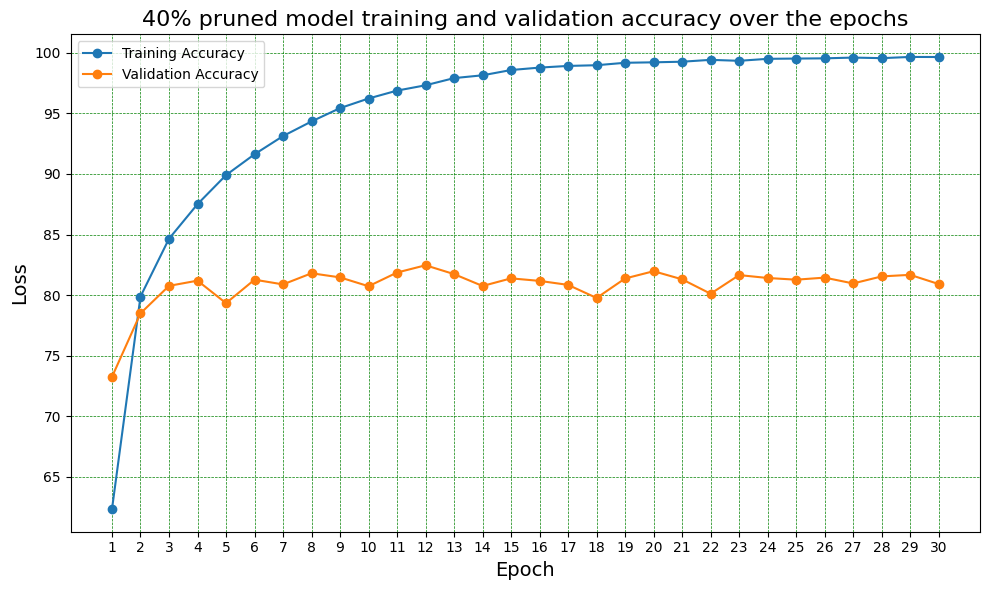

In [ ]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '40% pruned model training and validation accuracy over the epochs')

#### 50% Pruning

In [ ]:
prune_threshold = 0.50

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     base_capsnet_cifar10_ccm_model_ccm, caps_dim=8,
                                                     layers_to_prune=layers_to_prune_dict)

In [ ]:
pruned_50pc_base_capsnet_cifar10_model = ccmp.prune_multilayer_capsnet_layers(pretrained_base_capsnet_cifar10_ccm_model,
                                                                         input_channels=3,
                                                                         n_class=10,
                                                                         n_caps_layers=0,
                                                                         prim_caps_dim=8,
                                                                         model_layers_to_prune=layers_to_prune_dict.keys(),
                                                                         channels_to_preserve=channels_to_preserve,
                                                                         device=device)

pruned_50pc_base_capsnet_cifar10_model.name = 'pruned_50pc_base_capsnet_cifar10_model'
pruned_50pc_base_capsnet_cifar10_model = pruned_50pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
n_epochs=30
criterion = caps.CapsNetLoss(n_class)

best_pruned_50pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_50pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

01/17 12:49:16 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8011, Top 1 Acc=9.38, Top 5 Acc=64.06
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.8011, Top 1 Acc=9.38, Top 5 Acc=64.06
01/17 12:49:28 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6021, Top 1 Acc=21.08, Top 5 Acc=68.75
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.6021, Top 1 Acc=21.08, Top 5 Acc=68.75
01/17 12:49:39 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5177, Top 1 Acc=31.27, Top 5 Acc=79.91
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5177, Top 1 Acc=31.27, Top 5 Acc=79.91
01/17 12:49:51 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4695, Top 1 Acc=37.95, Top 5 Acc=84.67
INFO:ca

CPU times: user 1h 15min 55s, sys: 7.51 s, total: 1h 16min 2s
Wall time: 1h 15min 56s


In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(pruned_50pc_base_capsnet_cifar10_model,
                        inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Flops = 218603008.0
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Params = 668576.0


##### Plots for losses and accuracies

In [ ]:
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_accuracy']

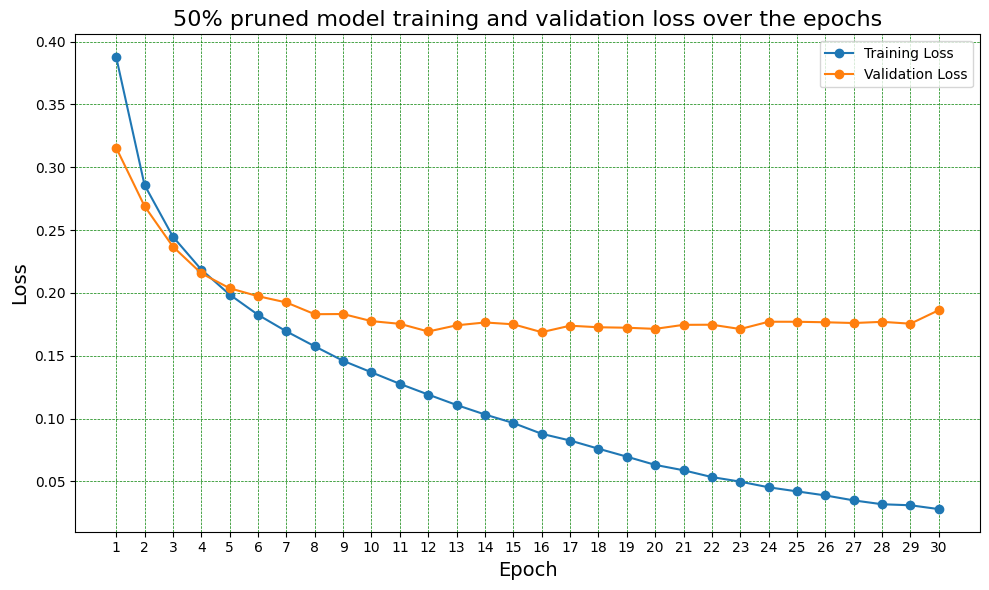

In [ ]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '50% pruned model training and validation loss over the epochs')

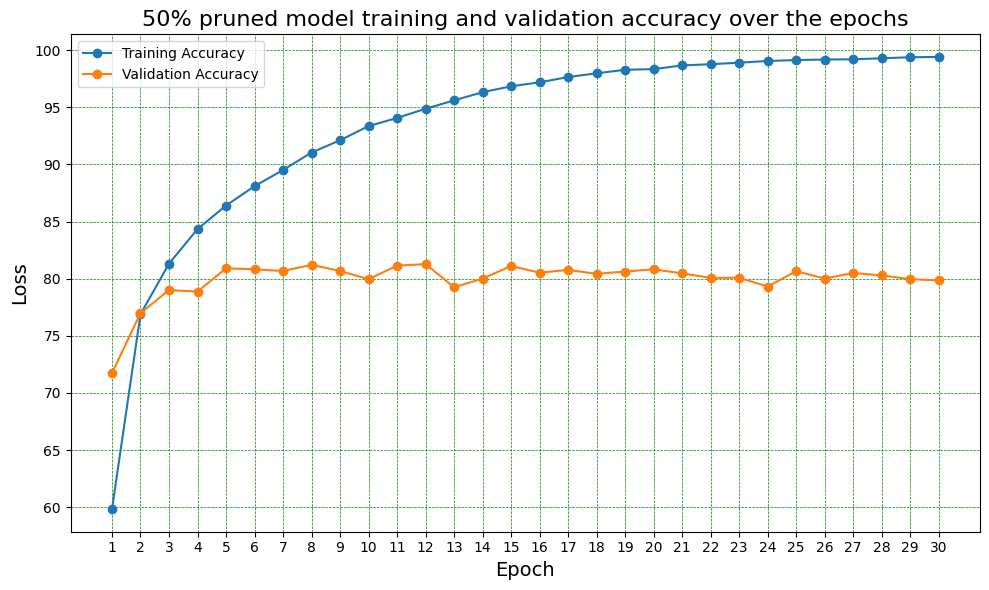

In [ ]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '50% pruned model training and validation accuracy over the epochs')

#### 60% Pruning

In [ ]:
prune_threshold = 0.60

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     base_capsnet_cifar10_ccm_model_ccm, caps_dim=8,
                                                     layers_to_prune=layers_to_prune_dict)

In [ ]:
pruned_60pc_base_capsnet_cifar10_model = ccmp.prune_multilayer_capsnet_layers(pretrained_base_capsnet_cifar10_ccm_model,
                                                                        input_channels=3,
                                                                        n_class=10,
                                                                        n_caps_layers=0,
                                                                        prim_caps_dim=8,
                                                                        model_layers_to_prune=layers_to_prune_dict.keys(),
                                                                        channels_to_preserve=channels_to_preserve,
                                                                        device=device)

pruned_60pc_base_capsnet_cifar10_model.name = 'pruned_60pc_base_capsnet_cifar10_model'
pruned_60pc_base_capsnet_cifar10_model = pruned_60pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(32, 56, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(56, 104, kernel_size=(5, 5), stride=(1, 1), padding=valid, bias=False)
    (bn): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(104, 104, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
# %%time
# n_epochs=30
# criterion = caps.CapsNetLoss(n_class)

# best_pruned_60pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
#                                                              pruned_60pc_base_capsnet_cifar10_model,
#                                                              criterion,
#                                                              train_loader,
#                                                              test_loader,
#                                                              CIFAR10_TRAIN_DIR,
#                                                              logger,
#                                                              device=device)

01/17 02:05:13 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7998, Top 1 Acc=9.38, Top 5 Acc=53.12
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7998, Top 1 Acc=9.38, Top 5 Acc=53.12
01/17 02:05:23 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5918, Top 1 Acc=22.79, Top 5 Acc=73.82
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.5918, Top 1 Acc=22.79, Top 5 Acc=73.82
01/17 02:05:33 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5098, Top 1 Acc=31.13, Top 5 Acc=81.87
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.5098, Top 1 Acc=31.13, Top 5 Acc=81.87
01/17 02:05:42 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4673, Top 1 Acc=36.97, Top 5 Acc=85.59
INFO:ca

CPU times: user 1h 2min 51s, sys: 6.34 s, total: 1h 2min 57s
Wall time: 1h 2min 52s


In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(pruned_60pc_base_capsnet_cifar10_model,
                        inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_60pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_60pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_60pc_base_capsnet_cifar10_model CIFAR10 60.0% pruned Flops = 155544576.0
pruned_60pc_base_capsnet_cifar10_model CIFAR10 60.0% pruned Params = 463688.0


#####Plots for losses and accuracies

In [ ]:
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_60pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_60pc_base_capsnet_cifar10_model['epoch_accuracy']

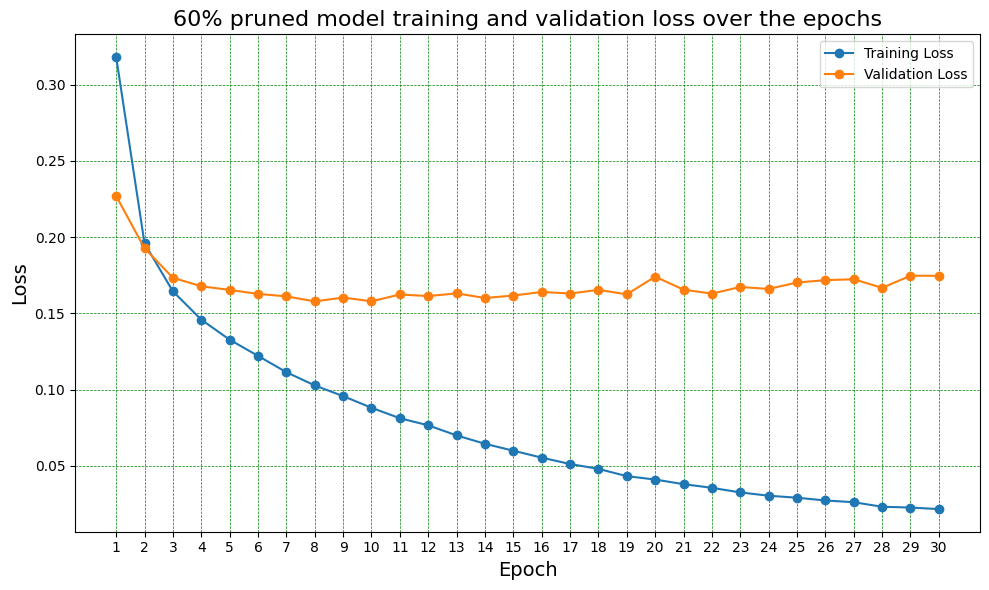

In [ ]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '60% pruned model training and validation loss over the epochs')

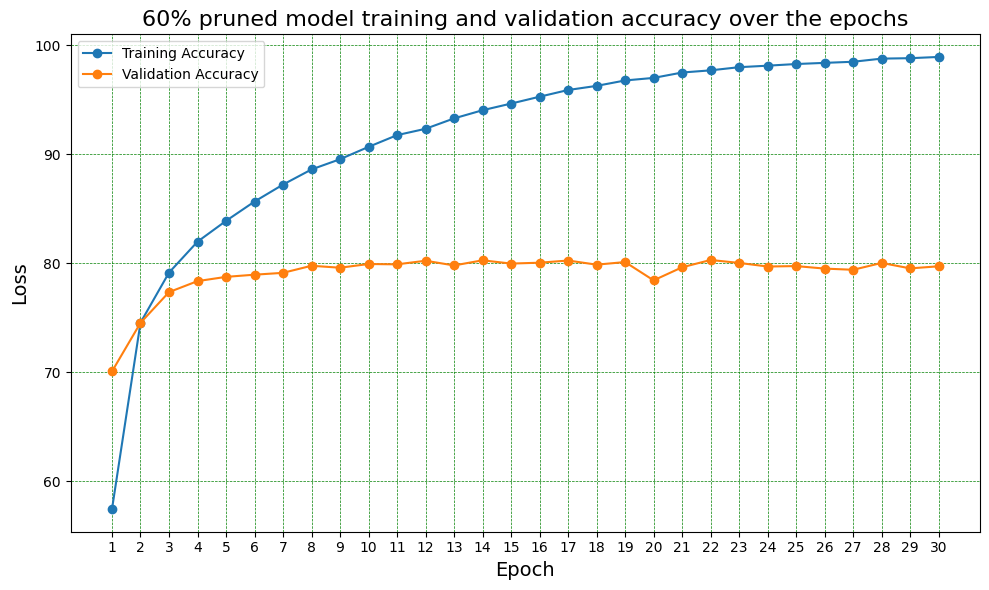

In [ ]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '60% pruned model training and validation accuracy over the epochs')

#### Plots for Unpruned and Pruned CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/32Caps8Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_BaseCapsNet_CIFAR10_Epoch30_of_30.pt')
pruned_20pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_20pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
pruned_40pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_40pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

models = [trained_base_capsnet_cifar10_model,
          pruned_20pc_base_capsnet_cifar10_model,
          pruned_25pc_base_capsnet_cifar10_model,
          pruned_40pc_base_capsnet_cifar10_model,
          pruned_50pc_base_capsnet_cifar10_model,
          pruned_60pc_base_capsnet_cifar10_model]

n_epochs = 30

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][1]

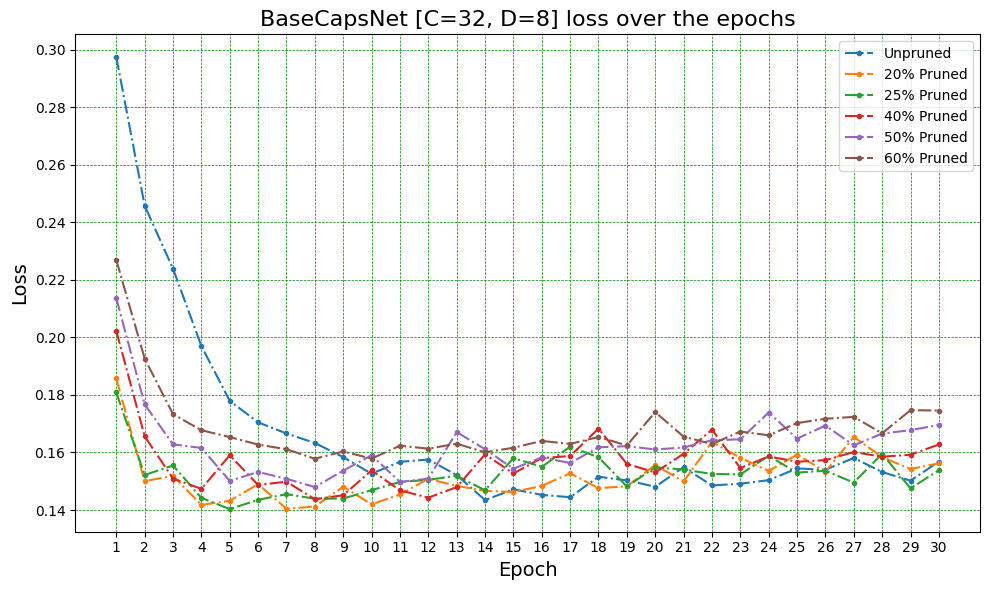

In [ ]:
plot_line_chart(epoch_losses, ['Unpruned', '20% Pruned', '25% Pruned', '40% Pruned', '50% Pruned', '60% Pruned'],
                'Epoch', 'Loss', 'BaseCapsNet [C=32, D=8] loss over the epochs',
                marker='.', line='-.')

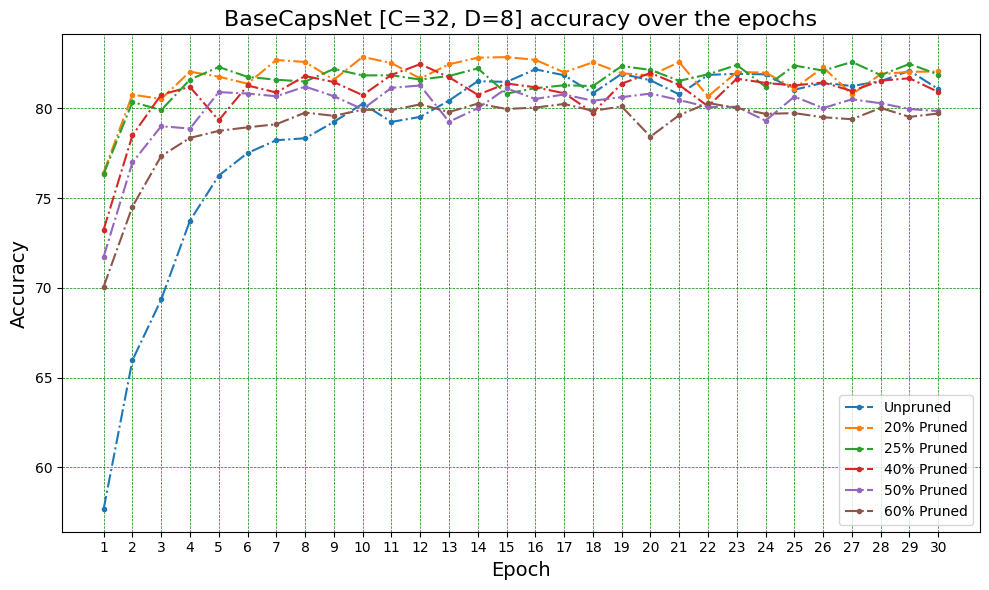

In [ ]:
plot_line_chart(epoch_accuracies, ['Unpruned', '20% Pruned', '25% Pruned', '40% Pruned', '50% Pruned', '60% Pruned'],
                'Epoch', 'Accuracy', 'BaseCapsNet [C=32, D=8] accuracy over the epochs',
                marker='.', line='-.')

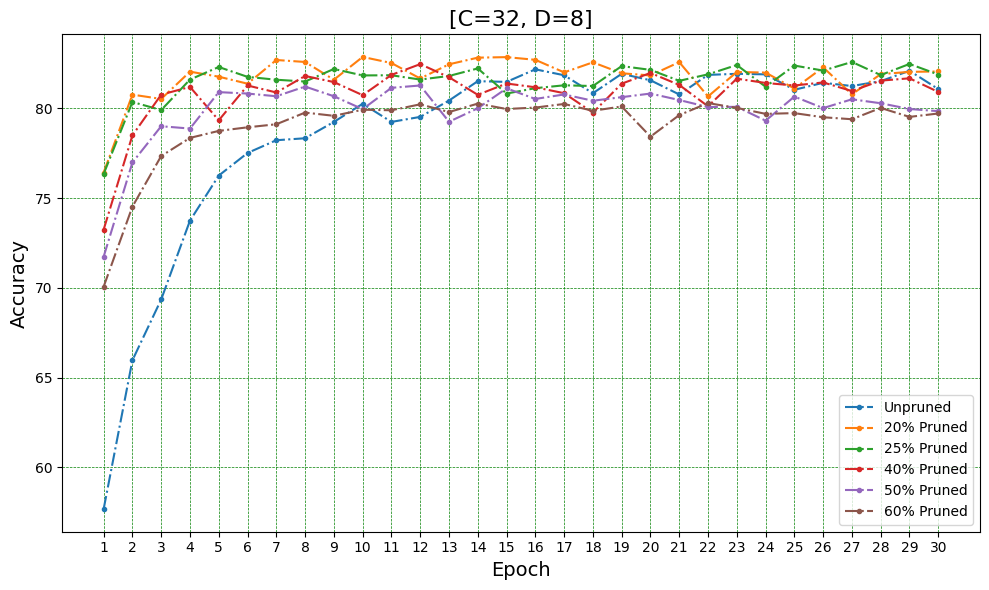

In [ ]:
plot_line_chart(epoch_accuracies, ['Unpruned', '20% Pruned', '25% Pruned', '40% Pruned', '50% Pruned', '60% Pruned'],
                'Epoch', 'Accuracy', '[C=32, D=8]',
                marker='.', line='-.')